In [1]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model, fit_report
from lmfit.models import LinearModel
from pandas import read_csv
from scipy.stats import gaussian_kde

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath('./../plots/temp')+'/'

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)

from pyresample.geometry import SwathDefinition
from pyresample import kd_tree, image
import cartopy.crs as ccrs
import matplotlib.path as mpath

##################


h3p_density = fits.open('h3p_dens_v2.fits', ignore_missing_end=True)[0].data
h3p_temperature = fits.open('h3p_temp_v2.fits', ignore_missing_end=True)[0].data
h3p_density_errs = fits.open('h3p_dens_errs_v2.fits', ignore_missing_end=True)[0].data
h3p_temperature_errs = fits.open('h3p_temp_errs_v2.fits', ignore_missing_end=True)[0].data
h3p_radiance = fits.open('h3p_radiance_v2.fits', ignore_missing_end=True)[0].data
h3p_radiance_errs = fits.open('h3p_radiance_errs_v2.fits', ignore_missing_end=True)[0].data

eff_ion_drift = fits.open('eff_ion_drift.fits', ignore_missing_end=True)[0].data
eff_ion_drift_errs = fits.open('eff_ion_drift_errs.fits', ignore_missing_end=True)[0].data
eff_ion_drift_ss = fits.open('eff_ion_drift_ss.fits', ignore_missing_end=True)[0].data

ion_drift = fits.open('ion_drift.fits', ignore_missing_end=True)[0].data
ion_drift_errs = fits.open('ion_drift_errs.fits', ignore_missing_end=True)[0].data
ion_drift_prf = fits.open('ion_drift_prf.fits', ignore_missing_end=True)[0].data

h2_density = fits.open('h2_dens_v2.fits', ignore_missing_end=True)[0].data
h2_temperature = fits.open('h2_temp_v2.fits', ignore_missing_end=True)[0].data
h2_density_errs = fits.open('h2_dens_errs_v2.fits', ignore_missing_end=True)[0].data
h2_temperature_errs = fits.open('h2_temp_errs_v2.fits', ignore_missing_end=True)[0].data
h2_radiance = fits.open('h2_radiance_v2.fits', ignore_missing_end=True)[0].data
h2_radiance_errs = fits.open('h2_radiance_errs_v2.fits', ignore_missing_end=True)[0].data

################################################################################
################################################################################

cmlsel = read_csv("cml-sel.txt", sep="\s+", header=None)
cml = cmlsel[3].to_numpy()

sub_earth_lat = -3.098

ang_diam_first_scan = 40.59098 * (((71492 + 800) / 71492 - 1)*2 + 1)
# ang_diam_first_scan = 40.59098
r_first_scan = ang_diam_first_scan / (0.1) / 2

ang_diam_second_scan = 40.58867 * (((71492 + 800) / 71492 - 1)*2 + 1)
# ang_diam_second_scan = 40.58867
r_second_scan = ang_diam_second_scan / (0.1) / 2

north_pole_posangle = 0

init_x = 150  # - (15.5 * 0.183) / 0.1 
init_y = 182  # (99.5 * 0.183) / 0.1 

dat_first_scan = h3p_temperature[:16]
dat_second_scan = h3p_temperature[16:]

lat_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])
lon_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])

lat_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])
lon_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])

los_corr_array_first_scan = np.zeros([dat_first_scan.shape[0], dat_first_scan.shape[1]])
los_corr_array_second_scan = np.zeros([dat_second_scan.shape[0], dat_second_scan.shape[1]])

for j in range(dat_first_scan.shape[0]):
    for i in range(dat_first_scan.shape[1]):
        x = i - init_x
        y_first_scan = init_y - (0.1716 / 0.1 * j)  # * (0.288 / 0.2) # 15 * 0.183 / 16

        lat_first_scan, lon_first_scan, los_corr_first_scan = rhp.slit_to_lat_long(x, 
                                                              y_first_scan, 
                                                              r_first_scan, 
                                                              sub_earth_lat, 
                                                              north_pole_posangle, 
                                                              cml[j],
                                                             )

        lat_array_first_scan[j][i] = lat_first_scan[4]
        lon_array_first_scan[j][i] = lon_first_scan[4]
        los_corr_array_first_scan[j][i] = los_corr_first_scan[4]

for j in range(dat_second_scan.shape[0]):
    for i in range(dat_second_scan.shape[1]):
        x = i - init_x
        y_second_scan = init_y - (0.1747 / 0.1 * j)  # * (0.288 / 0.2) # 21 * 0.183 / 22

        lat_second_scan, lon_second_scan, los_corr_second_scan = rhp.slit_to_lat_long(x, 
                                                                y_second_scan, 
                                                                r_second_scan, 
                                                                sub_earth_lat, 
                                                                north_pole_posangle, 
                                                                cml[j + 16],
                                                               )

        lat_array_second_scan[j][i] = lat_second_scan[4]
        lon_array_second_scan[j][i] = lon_second_scan[4]
        los_corr_array_second_scan[j][i] = los_corr_second_scan[4]

los_corr_array = np.vstack([los_corr_array_first_scan, los_corr_array_second_scan])

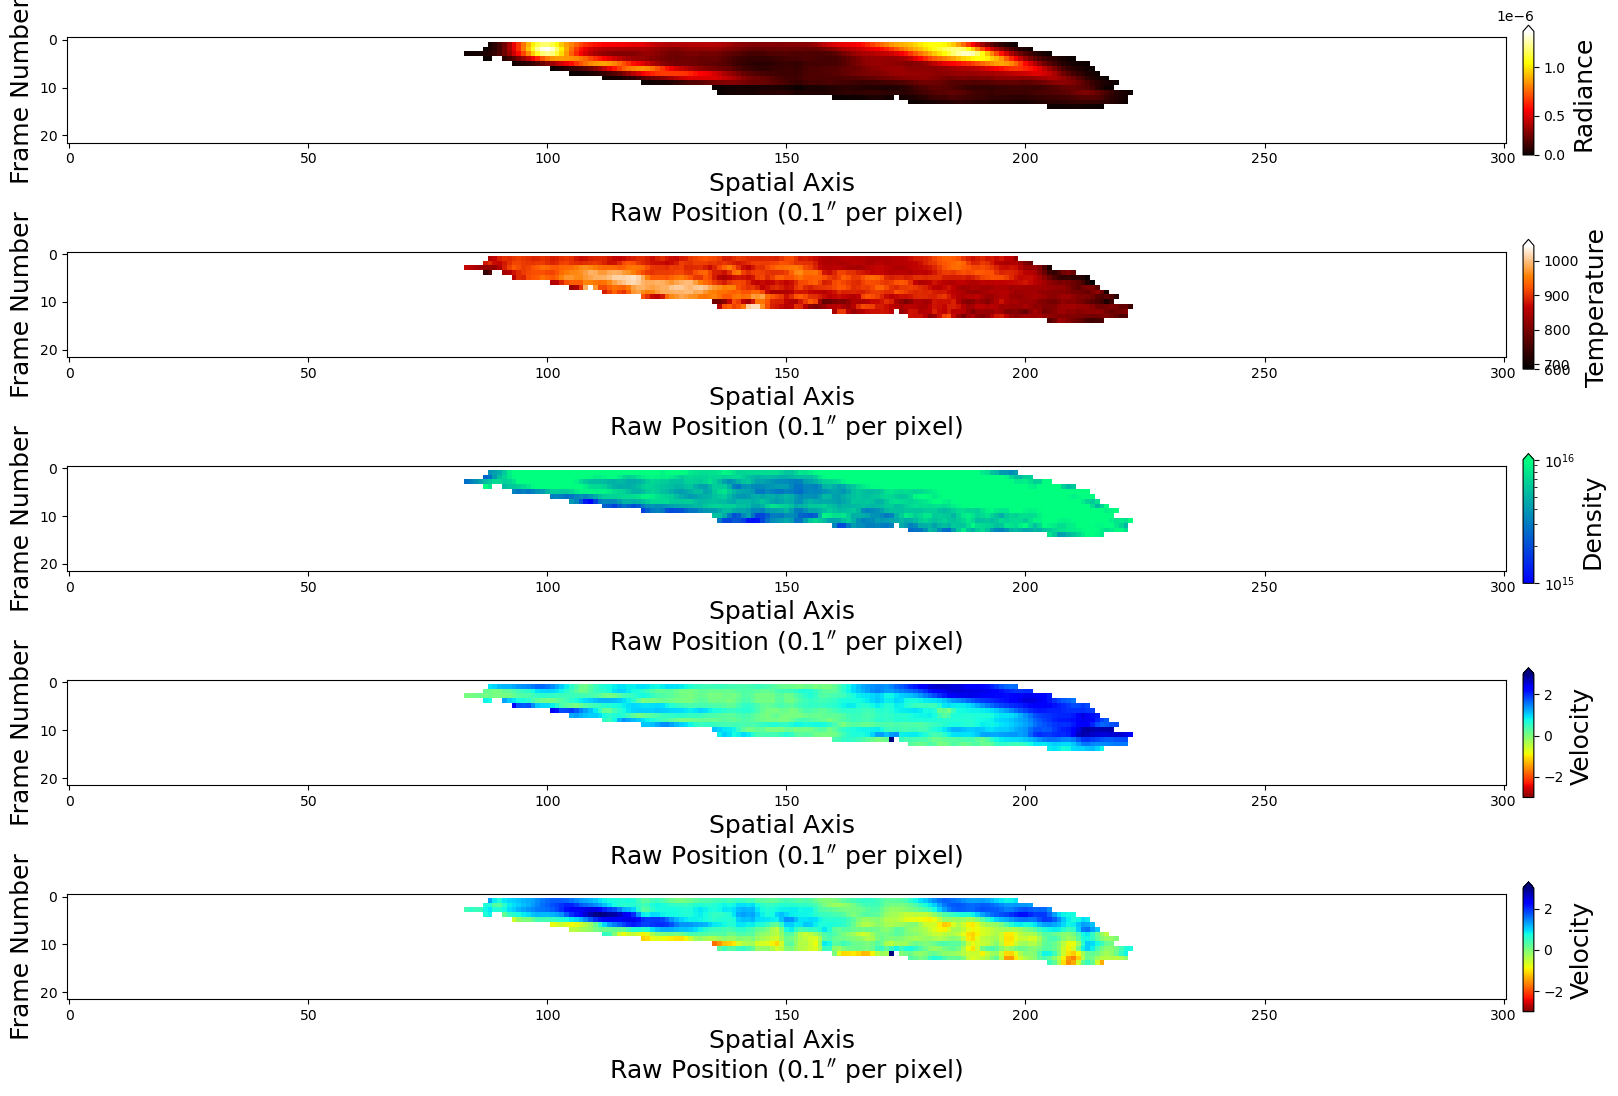

In [2]:
h3p_rad_los_corr = h3p_radiance*los_corr_array
h3p_dens_los_corr = h3p_density*los_corr_array

h3p_temp = h3p_temperature.copy()
h3p_vel = ion_drift_prf.copy()
h3p_eff_vel = eff_ion_drift.copy()


h3p_temp_errs = h3p_temperature_errs.copy()
h3p_dens_errs = h3p_density_errs.copy()
h3p_rad_errs = h3p_radiance_errs.copy()

h3p_rad_los_corr[(h3p_rad_los_corr*1e6) < 0.1] = np.nan
h3p_temp[h3p_temp > 1200] = np.nan
h3p_temp[h3p_temp < 550] = np.nan

h3p_temp[np.isnan(h3p_rad_los_corr)] = np.nan
h3p_rad_los_corr[np.isnan(h3p_temp)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_temp)] = np.nan
h3p_vel[np.isnan(h3p_temp)] = np.nan
h3p_eff_vel[np.isnan(h3p_vel)] = np.nan

h3p_temp[np.isnan(h3p_eff_vel)] = np.nan
h3p_rad_los_corr[np.isnan(h3p_eff_vel)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_eff_vel)] = np.nan
h3p_vel[np.isnan(h3p_eff_vel)] = np.nan

a = 16
b = 38

fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(511)
plt.imshow(h3p_rad_los_corr[a:b], cmap='hot', norm=colors.PowerNorm(gamma=1,))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Radiance',size=18)

fig.add_subplot(512)
plt.imshow(h3p_temp[a:b], cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature',size=18)

fig.add_subplot(513)
plt.imshow(h3p_dens_los_corr[a:b], cmap='winter', norm=colors.LogNorm(vmin=1e15, vmax=1e16))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density',size=18)

fig.add_subplot(514)
plt.imshow(np.abs(h3p_vel[a:b]), cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity',size=18)

fig.add_subplot(515)
plt.imshow(h3p_eff_vel[a:b], cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity',size=18)

In [27]:
finite_rad = h3p_rad_los_corr[a:b][np.isfinite(h3p_rad_los_corr[a:b])]
finite_dens = h3p_dens_los_corr[a:b][np.isfinite(h3p_dens_los_corr[a:b])]
finite_temp = h3p_temp[a:b][np.isfinite(h3p_temp[a:b])]
finite_vel = h3p_vel[a:b][np.isfinite(h3p_vel[a:b])]
finite_eff_vel = h3p_eff_vel[a:b][np.isfinite(h3p_eff_vel[a:b])]

print(np.corrcoef(finite_dens, finite_rad))
print(np.corrcoef(finite_rad, finite_temp))
print(np.corrcoef(finite_dens, finite_temp))
print(np.corrcoef(finite_temp, finite_vel))
print(np.corrcoef(finite_temp, finite_eff_vel))

dens = finite_dens
rad = finite_rad
temp = finite_temp
vel = finite_vel
eff_vel = finite_eff_vel

dens_rad = np.vstack([dens, rad])
temp_rad = np.vstack([temp, rad])
dens_temp = np.vstack([dens, temp])
vel_temp = np.vstack([vel, temp])
eff_vel_temp = np.vstack([eff_vel, temp])

kernel_dens_rad = gaussian_kde(dens_rad)
z_dens_rad = kernel_dens_rad(dens_rad)

kernel_temp_rad = gaussian_kde(temp_rad)
z_temp_rad = kernel_temp_rad(temp_rad)

kernel_dens_temp = gaussian_kde(dens_temp)
z_dens_temp = kernel_dens_temp(dens_temp)

kernel_temp_vel = gaussian_kde(vel_temp)
z_vel_temp = kernel_temp_vel(vel_temp)

kernel_eff_vel_temp = gaussian_kde(eff_vel_temp)
z_eff_vel_temp = kernel_eff_vel_temp(eff_vel_temp)

# fig, ax = plt.subplots()
# ax.scatter(eff_vel, temp, c=z_eff_vel_temp, s=10)
# ax.plot(np.log10(finite_dens), np.log10(finite_rad), 'r.')

[[1.         0.74783151]
 [0.74783151 1.        ]]
[[1.         0.37650542]
 [0.37650542 1.        ]]
[[ 1.         -0.27631423]
 [-0.27631423  1.        ]]
[[ 1.         -0.40397046]
 [-0.40397046  1.        ]]
[[1.         0.32041871]
 [0.32041871 1.        ]]


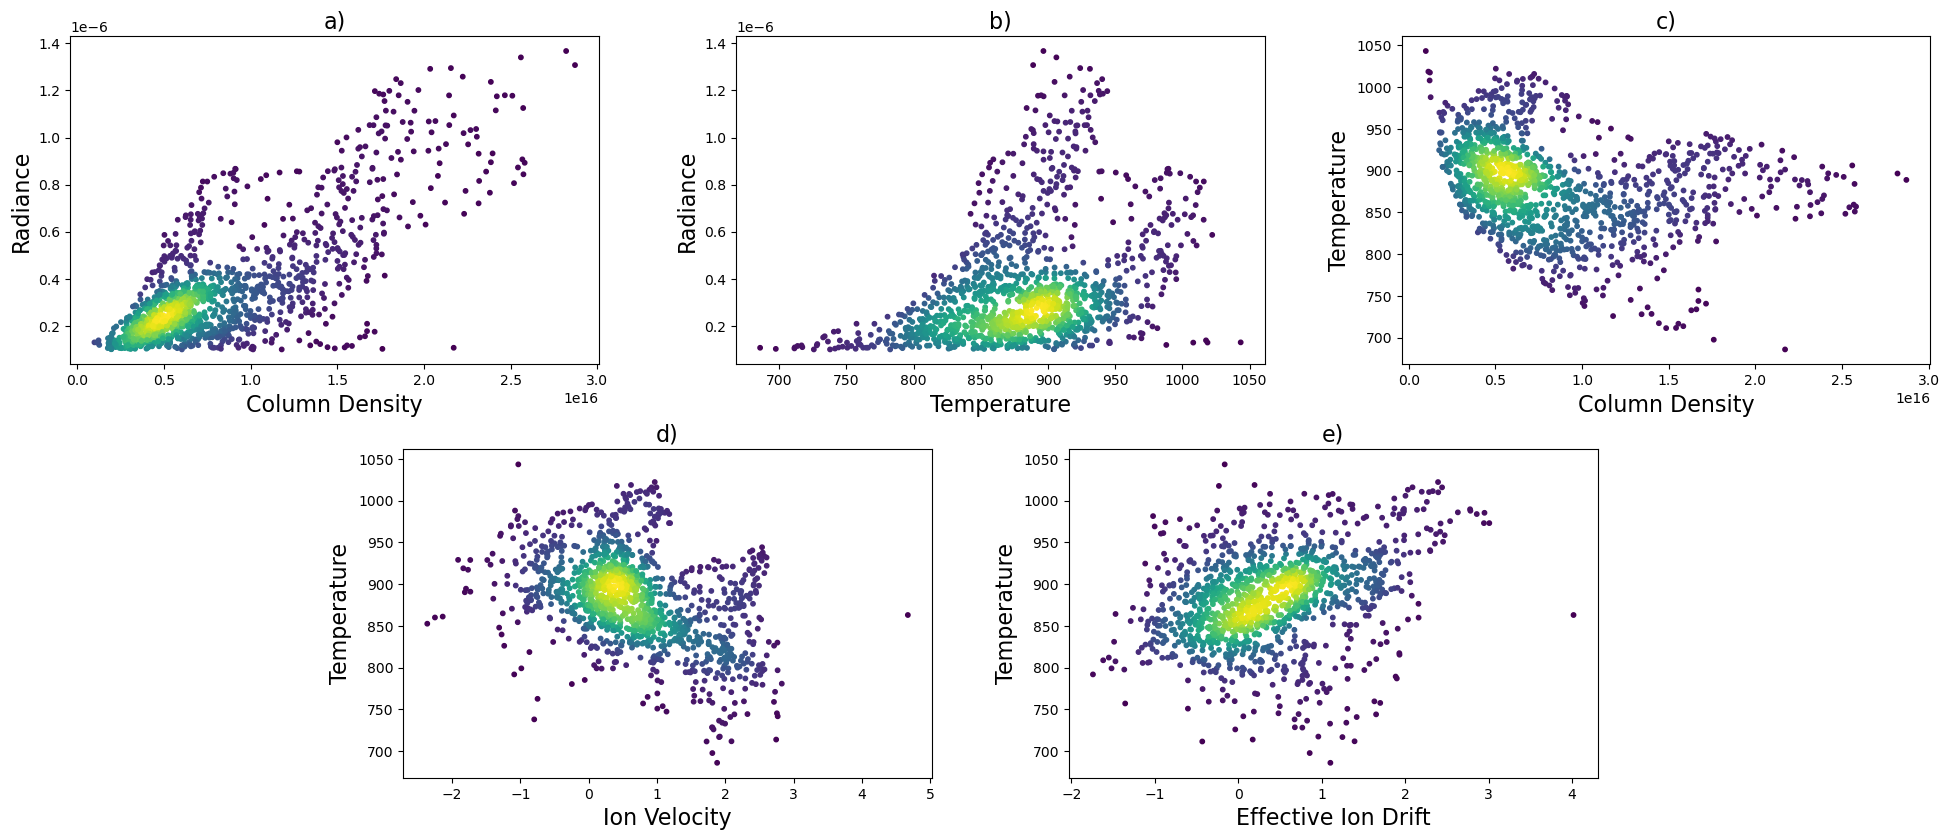

In [30]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(24, 15))

gs = gridspec.GridSpec(6, 6)

ax1 = fig.add_subplot(gs[:2, :2])
# ax1.plot(range(0,10), range(0,10))
ax1.set_xlabel('Column Density', fontsize=16)
ax1.set_ylabel('Radiance', fontsize=16)
ax1.set_title('a)', loc='center', fontsize=16)
# ax1.plot(np.log10(finite_dens), np.log10(finite_rad), 'r.')
ax1.scatter(dens, rad, c=z_dens_rad, s=10)

ax2 = fig.add_subplot(gs[:2, 2:4])
ax2.set_xlabel('Temperature', fontsize=16)
ax2.set_ylabel('Radiance', fontsize=16)
ax2.set_title('b)', loc='center', fontsize=16)
ax2.scatter(temp, rad, c=z_temp_rad, s=10)

ax3 = fig.add_subplot(gs[:2, 4:6])
ax3.set_xlabel('Column Density', fontsize=16)
ax3.set_ylabel('Temperature', fontsize=16)
ax3.set_title('c)', loc='center', fontsize=16)
ax3.scatter(dens, temp, c=z_dens_temp, s=10)

ax4 = fig.add_subplot(gs[2:4, 1:3])
ax4.set_xlabel('Ion Velocity', fontsize=16)
ax4.set_ylabel('Temperature', fontsize=16)
ax4.set_title('d)', loc='center', fontsize=16)
im4 = ax4.scatter(vel, temp, c=z_vel_temp, s=10)

# cbar4 = plt.colorbar(im4, ax=ax4, aspect=17, orientation="vertical", location='right')
# cbar4.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

ax5 = fig.add_subplot(gs[2:4, 3:5])
ax5.set_xlabel('Effective Ion Drift', fontsize=16)
ax5.set_ylabel('Temperature', fontsize=16)
ax5.set_title('e)', loc='center', fontsize=16)
im5 = ax5.scatter(eff_vel, temp, c=z_eff_vel_temp, s=10)

# cbar5 = plt.colorbar(im5, ax=ax5, aspect=17, orientation="vertical", location='right')
# cbar5.set_label(label=r'$\mathrm{log_{10} E_{H_2} (Wm^{-2}sr^{-1})}$', size=16, labelpad=5)

# ax3 = plt.subplot(gs[2:4, 1:3])
# ax3.plot(range(0,10), range(0,10))

fig.subplots_adjust(hspace=0.7, wspace=0.7)

plt.savefig(plots_dir+'/correlation.jpg', dpi=300, bbox_inches='tight')

In [28]:
plots_dir

'/Users/ruoyanwang/Documents/leicester/h3p/02jun17/plots/temp/'

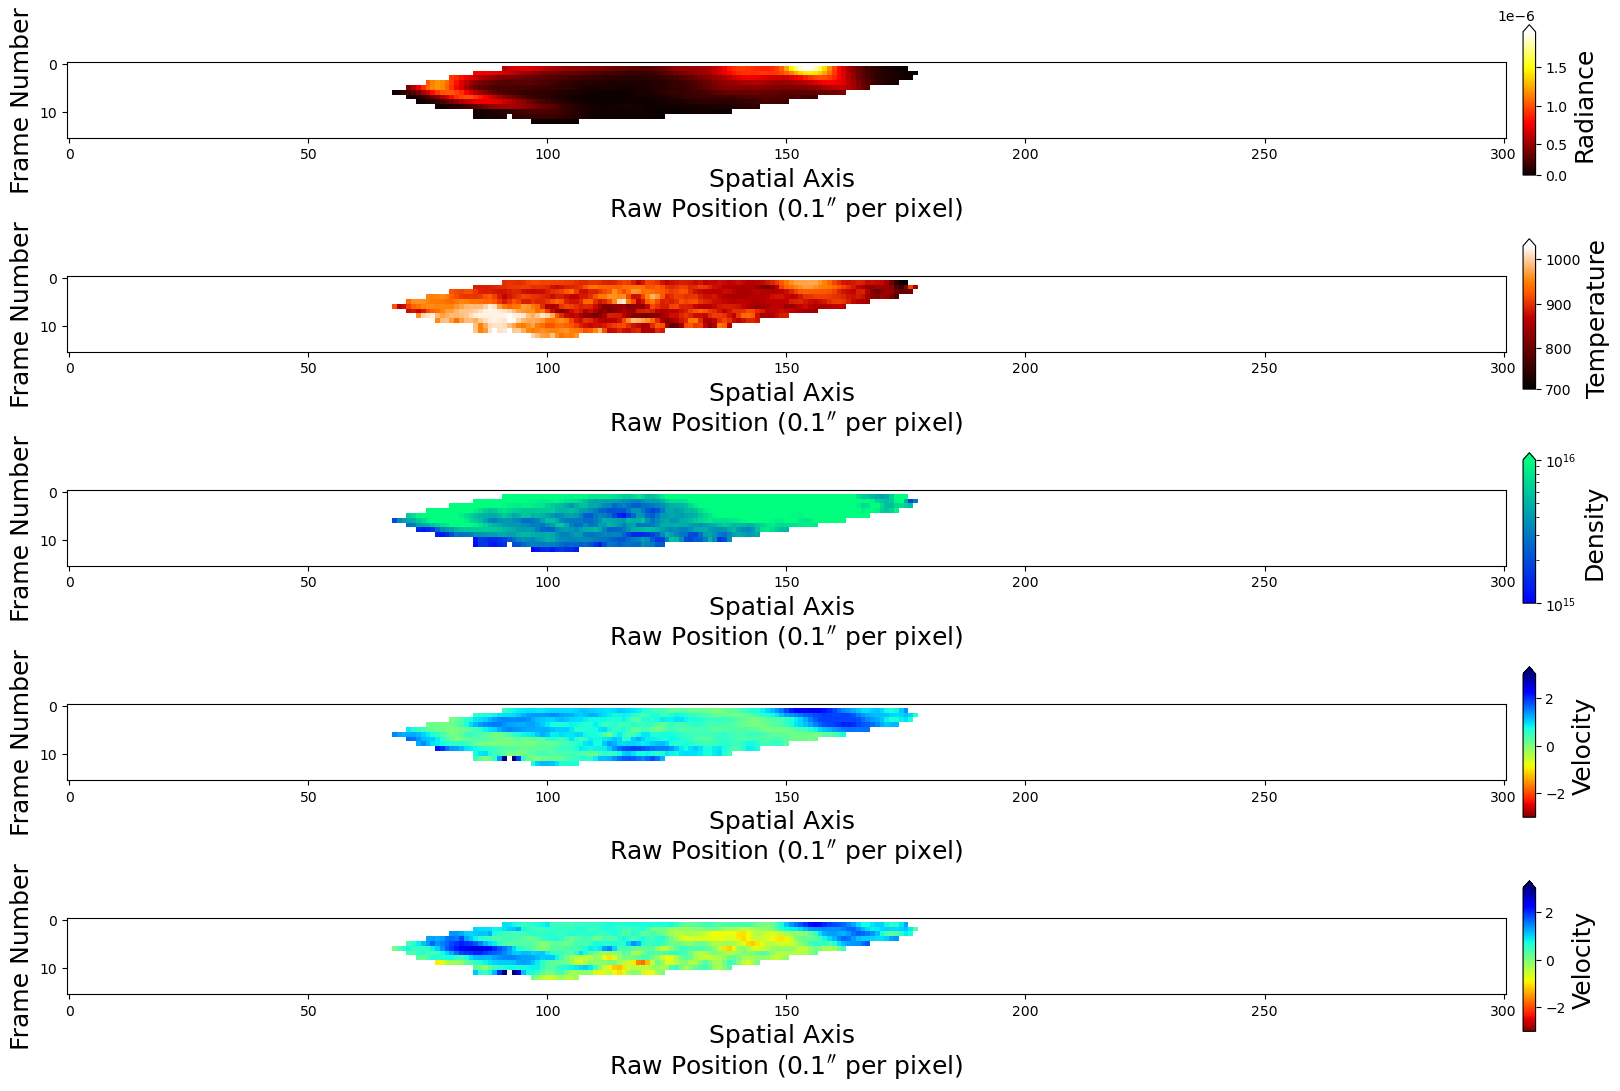

In [6]:
h3p_rad_los_corr = h3p_radiance*los_corr_array
h3p_dens_los_corr = h3p_density*los_corr_array

h3p_temp = h3p_temperature.copy()
h3p_vel = ion_drift_prf.copy()
h3p_eff_vel = eff_ion_drift.copy()


# h3p_rad_los_corr[h3p_rad_los_corr < 1e-8] = np.nan
# h3p_dens_los_corr[h3p_dens_los_corr < 1e10] = np.nan

# h3p_rad_los_corr[:,:90] = np.nan
# h3p_radiance_los_corr[:,215:] = np.nan
h3p_rad_los_corr[h3p_rad_los_corr < 1e-7] = np.nan

h3p_temp[np.isnan(h3p_rad_los_corr)] = np.nan
h3p_rad_los_corr[np.isnan(h3p_temp)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_temp)] = np.nan
h3p_vel[np.isnan(h3p_temp)] = np.nan
h3p_eff_vel[np.isnan(h3p_vel)] = np.nan

h3p_temp[np.isnan(h3p_eff_vel)] = np.nan
h3p_rad_los_corr[np.isnan(h3p_eff_vel)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_eff_vel)] = np.nan
h3p_vel[np.isnan(h3p_eff_vel)] = np.nan

# eff_ion_drift[:,:55] = np.nan
# eff_ion_drift[:,235:] = np.nan
# h3p_int[np.isnan(eff_ion_drift)] = np.nan
# h3p_radiance[np.isnan(eff_ion_drift)] = np.nan

# h3p_density[:,:55] = np.nan

a = 0
b = 16

fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(511)
plt.imshow(h3p_rad_los_corr[a:b], cmap='hot', norm=colors.PowerNorm(gamma=1,))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Radiance',size=18)

fig.add_subplot(512)
plt.imshow(h3p_temp[a:b], cmap='gist_heat', norm=colors.PowerNorm(gamma=1))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature',size=18)

fig.add_subplot(513)
plt.imshow(h3p_dens_los_corr[a:b], cmap='winter', norm=colors.LogNorm(vmin=1e15, vmax=1e16))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density',size=18)

fig.add_subplot(514)
plt.imshow(np.abs(h3p_vel[a:b]), cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity',size=18)

fig.add_subplot(515)
plt.imshow(h3p_eff_vel[a:b], cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity',size=18)

[[1.         0.25880467]
 [0.25880467 1.        ]]


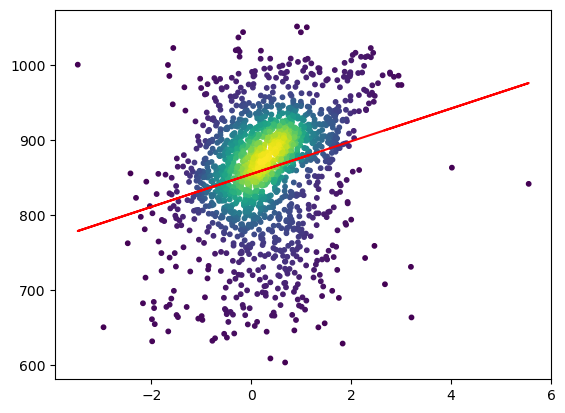

In [33]:
from scipy.stats import gaussian_kde

h3p_temperature[h3p_temperature > 1200] = np.nan
h3p_temperature[h3p_temperature_errs > 100] = np.nan

eff_ion_drift[np.isnan(h3p_temperature)] = np.nan
h3p_temperature[np.isnan(eff_ion_drift)] = np.nan

finite_eff_ion_drift = eff_ion_drift[16:][np.isfinite(eff_ion_drift[16:])]
finite_h3p_temperature = h3p_temperature[16:][np.isfinite(h3p_temperature[16:])]

# Calculate the point density
x = finite_eff_ion_drift.copy()
y = finite_h3p_temperature.copy()

xy = np.vstack([finite_eff_ion_drift,finite_h3p_temperature])
z = gaussian_kde(xy)(xy)

a, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10)
ax.plot(x, a*x+b, 'r', label = 'best fit')

print(np.corrcoef(x,y))

[[1.         0.56596273]
 [0.56596273 1.        ]]


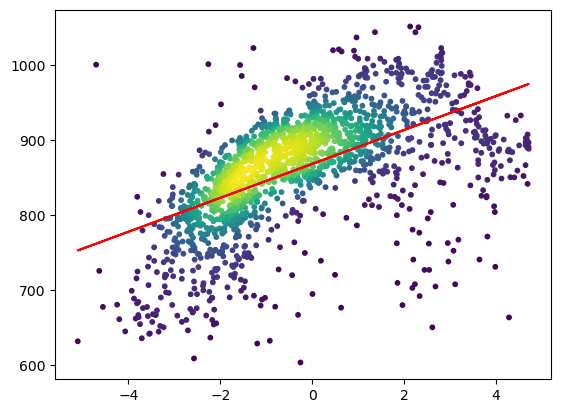

In [31]:
from scipy.stats import gaussian_kde

h3p_temperature[h3p_temperature > 1200] = np.nan
h3p_temperature[h3p_temperature_errs > 100] = np.nan

ion_drift[ion_drift < -6] = np.nan
ion_drift[ion_drift > 6] = np.nan

ion_drift[np.isnan(h3p_temperature)] = np.nan
h3p_temperature[np.isnan(ion_drift)] = np.nan
h3p_dens_los_corr[np.isnan(h3p_temperature)] = np.nan


finite_ion_drift = ion_drift[16:][np.isfinite(ion_drift[16:])]
finite_h3p_temperature = h3p_temperature[16:][np.isfinite(h3p_temperature[16:])]

# Calculate the point density
x = finite_ion_drift.copy()
y = finite_h3p_temperature.copy()

xy = np.vstack([finite_ion_drift,finite_h3p_temperature])
z = gaussian_kde(xy)(xy)

a, b = np.polyfit(x, y, 1)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10)
ax.plot(x, a*x+b, 'r', label = 'best fit')

print(np.corrcoef(x,y))

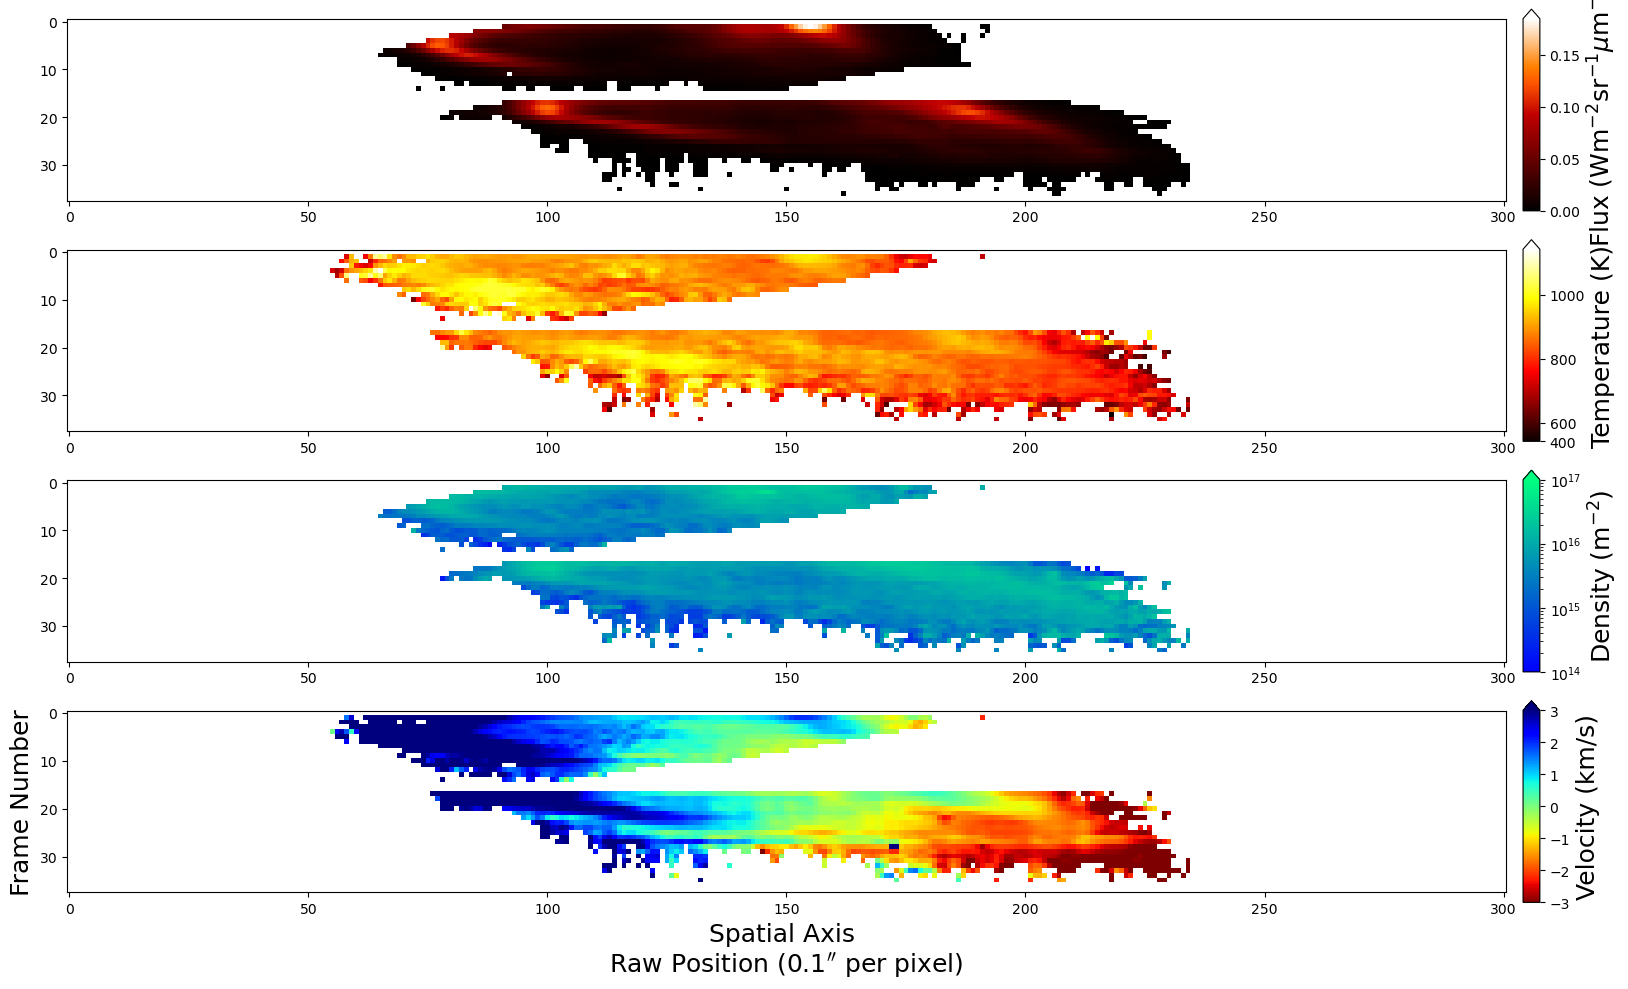

In [9]:
fig = plt.figure(figsize=(18,10), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h3p_int_los_corr, cmap='gist_heat', norm=colors.PowerNorm(gamma=1,))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$',size=18)

# plt.contour(eff_ion_drift)

h3p_temperature_errs2 = h3p_temperature_errs.copy()
h3p_temperature_errs2[h3p_temperature_errs2 > 100] = np.nan

fig.add_subplot(412)
plt.imshow(h3p_temperature, cmap='hot', norm=colors.PowerNorm(gamma=1, ))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature (K)',size=18)

# plt.contour(h3p_temperature)
# plt.contour(h3p_dens_los_corr)

fig.add_subplot(413)
plt.imshow(h3p_dens_los_corr, cmap='winter', norm=colors.LogNorm(vmin=1e14, vmax=1e17))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density (m$^{-2}$)',size=18)

fig.add_subplot(414)
plt.imshow(ion_drift, cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity (km/s)',size=18)

# fig.add_subplot(414)
# plt.imshow(h2_density, cmap='winter', norm=colors.LogNorm(vmin=1e23, vmax=1e27))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# # plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
# plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density (m$^{-2}$)',size=18)

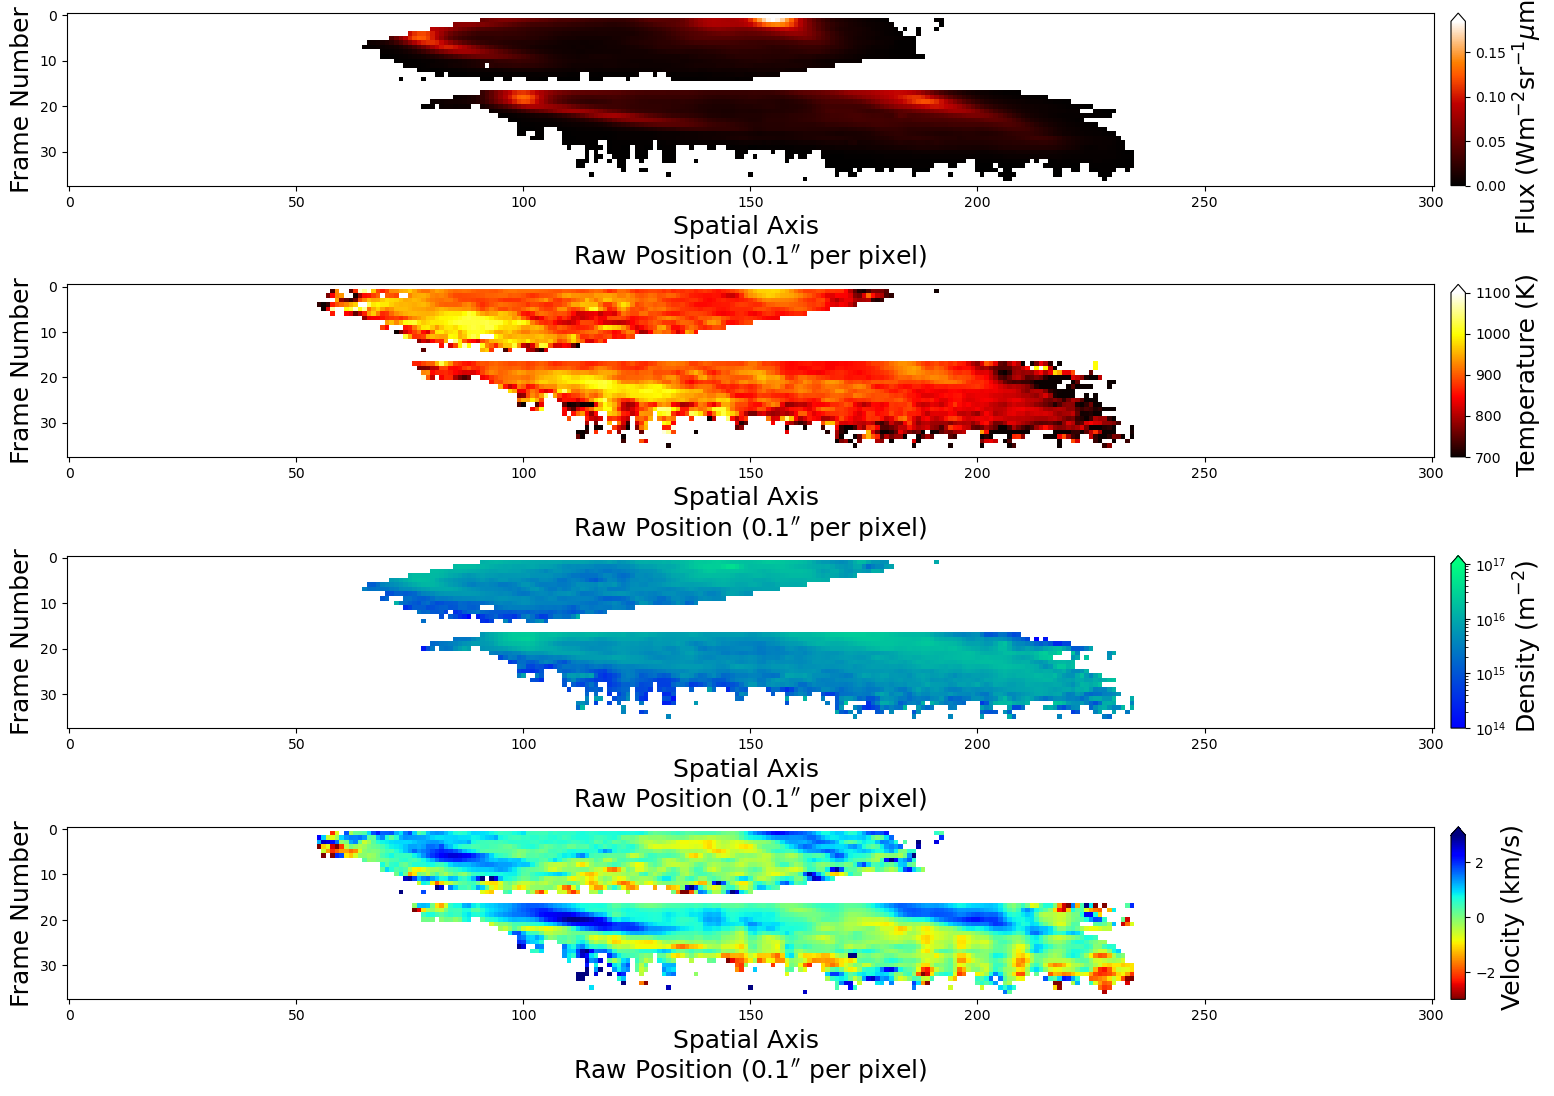

In [10]:
fig = plt.figure(figsize=(18,11), tight_layout=True)

fig.add_subplot(411)
plt.imshow(h3p_int_los_corr, cmap='gist_heat', norm=colors.PowerNorm(gamma=1,))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$',size=18)

# plt.contour(eff_ion_drift)

fig.add_subplot(412)
plt.imshow(h3p_temperature, cmap='hot', norm=colors.PowerNorm(gamma=1, vmin=700, vmax=1100))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Temperature (K)',size=18)

# plt.contour(h3p_temperature)
# plt.contour(h3p_dens_los_corr)

fig.add_subplot(413)
plt.imshow(h3p_dens_los_corr, cmap='winter', norm=colors.LogNorm(vmin=1e14, vmax=1e17))
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
# plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density (m$^{-2}$)',size=18)

fig.add_subplot(414)
plt.imshow(eff_ion_drift, cmap='jet_r', vmin=-3, vmax=3)
plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
plt.ylabel('Frame Number', fontsize=18)
plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Velocity (km/s)',size=18)

# fig.add_subplot(414)
# plt.imshow(h2_density, cmap='winter', norm=colors.LogNorm(vmin=1e23, vmax=1e27))
# plt.xlabel('Spatial Axis \nRaw Position (0.1$^{\prime\prime}$ per pixel)', fontsize=18)
# plt.ylabel('Frame Number', fontsize=18)
# # plt.title('a) H$_3^{+}$ - tempensity', loc='left', fontsize=18)
# plt.colorbar(extend='max', aspect=12, pad=0.01).set_label(label='Density (m$^{-2}$)',size=18)